In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
# Define the paths to the DUT-OMRON dataset and saliency maps
image_folder1 = r'C:\Users\SAI KEERTHAN\Downloads\DUT-OMRON-image\DUT-OMRON-image'
saliency_folder1 = r'C:\Users\SAI KEERTHAN\Downloads\DUT-OMRON-gt-pixelwise.zip\pixelwiseGT-new-PNG'

# Define the paths to the DUTS dataset and saliency maps
image_folder2 = r'C:\Users\SAI KEERTHAN\Downloads\DUTS-TE\DUTS-TE\DUTS-TE-Image'
saliency_folder2 = r'C:\Users\SAI KEERTHAN\Downloads\DUTS-TE\DUTS-TE\DUTS-TE-Mask'

image_paths1 = glob.glob(os.path.join(image_folder1, '*.jpg'))
saliency_paths1 = glob.glob(os.path.join(saliency_folder1, '*.png'))

image_paths2 = glob.glob(os.path.join(image_folder2, '*.jpg'))
saliency_paths2 = glob.glob(os.path.join(saliency_folder2, '*.png'))

print("Total DUT-OMRON dataset size for images:", len(image_paths1))
print("Total DUT-OMRON dataset size for saliency maps:", len(saliency_paths1))

print("Total ECSSD dataset size for images:", len(image_paths2))
print("Total ECSSD dataset size for saliency maps:", len(saliency_paths2))

train_images1, test_images1, train_saliency1, test_saliency1 = train_test_split(image_paths1, saliency_paths1, test_size=0.2, random_state=42)
train_images1, validation_images1, train_saliency1, validation_saliency1 = train_test_split(train_images1, train_saliency1, test_size=0.25, random_state=42)

train_images2, test_images2, train_saliency2, test_saliency2 = train_test_split(image_paths2, saliency_paths2, test_size=0.2, random_state=42)
train_images2, validation_images2, train_saliency2, validation_saliency2 = train_test_split(train_images2, train_saliency2, test_size=0.25, random_state=42)

train_images = train_images1
train_saliency = train_saliency1

validation_images = validation_images1
validation_saliency = validation_saliency1

test_images = test_images2
test_saliency = test_saliency2

print("\nDUT-OMRON Training set size:", len(train_images1))
print("DUT-OMRON Validation set size:", len(validation_images1))
print("DUT-OMRON Testing set size:", len(test_images1))

print("\nECSSD Training set size:", len(train_images2))
print("ECSSD Validation set size:", len(validation_images2))
print("ECSSD Testing set size:", len(test_images2))

print("\nOur model Training set size:", len(train_images))
print("Our model Validation set size:", len(validation_images))
print("Our model Testing set size:", len(test_images))

# Load the model from the saved HDF5 file
cnn_model = load_model('60_32_0.01_DUT-OMRON_ECSSD.h5')

# Now you can use the loaded_model for predictions or further training


Total DUT-OMRON dataset size for images: 5168
Total DUT-OMRON dataset size for saliency maps: 5168
Total ECSSD dataset size for images: 1000
Total ECSSD dataset size for saliency maps: 1000

DUT-OMRON Training set size: 3100
DUT-OMRON Validation set size: 1034
DUT-OMRON Testing set size: 1034

ECSSD Training set size: 600
ECSSD Validation set size: 200
ECSSD Testing set size: 200

Our model Training set size: 3100
Our model Validation set size: 1034
Our model Testing set size: 200


In [3]:
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0 
    return image

def preprocess_saliency(saliency_path):
    saliency = tf.keras.preprocessing.image.load_img(saliency_path, target_size=(111, 111), color_mode='grayscale')
    saliency = tf.keras.preprocessing.image.img_to_array(saliency)
    saliency = saliency / 255.0  
    return saliency


def load_data(image_paths, saliency_paths):
    
    images = []
    saliency_maps = []
    
    for image_path, saliency_path in zip(image_paths, saliency_paths):
        
        image = preprocess_image(image_path)
        saliency = preprocess_saliency(saliency_path)
        
        images.append(image)
        saliency_maps.append(saliency)
        
    images = np.array(images)
    saliency_maps = np.array(saliency_maps)
    
    return images, saliency_maps

In [4]:
train_images, train_saliency = load_data(train_images, train_saliency)

validation_images, validation_saliency = load_data(validation_images, validation_saliency)

test_images, test_saliency = load_data(test_images, test_saliency)

In [5]:
predictions = cnn_model.predict([test_images, test_images])

7/7 [==============================] - 4s 382ms/step


In [56]:
def calculate_precision_recall_fmeasure(y_true, y_pred):
    # Flatten the ground truth and predicted saliency maps
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Threshold the predicted saliency map to convert it into binary format
    y_pred_binary = np.where(y_pred_flat >= 0.162, 1, 0)
    
    # Calculate True Positives, False Positives, False Negatives
    tp = np.sum((y_true_flat == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_binary == 0))
    
    # Calculate precision, recall, and F-measure
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f_measure = 2 * (precision * recall) / (precision + recall + 1e-9)
    
    return precision, recall, f_measure

precision, recall, f_measure = calculate_precision_recall_fmeasure(test_saliency, predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


Precision: 0.35332935060257065
Recall: 0.5557031330961336
F-measure: 0.4319894623122277


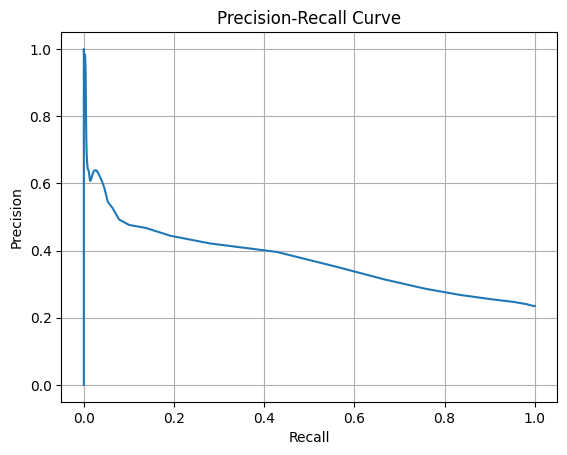

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'predictions' variable containing the predicted saliency map and the ground truth saliency maps

# Function to calculate precision and recall for a given threshold
def calculate_precision_recall(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(np.uint8)
    
    tp = np.sum((y_true == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    
    return precision, recall

# Assuming you have the 'test_saliency' variable containing the ground truth saliency maps
thresholds = np.linspace(0, 1, num=100)  # Generate 100 equally spaced thresholds from 0 to 1

precisions = []
recalls = []

for threshold in thresholds:
    precision, recall = calculate_precision_recall(test_saliency, predictions, threshold)
    precisions.append(precision)
    recalls.append(recall)

# Plot the precision-recall curve
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 29ms/step


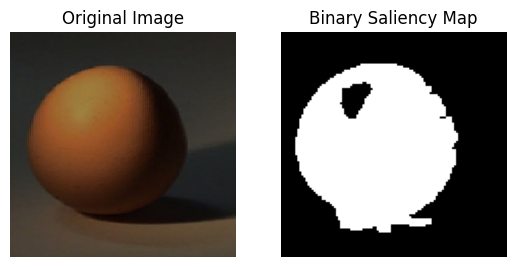

In [19]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\Egg.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.188
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 32ms/step


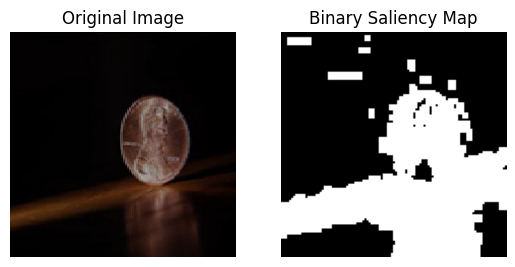

In [38]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\coin.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.184
# Apply thresholdi9g to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 30ms/step


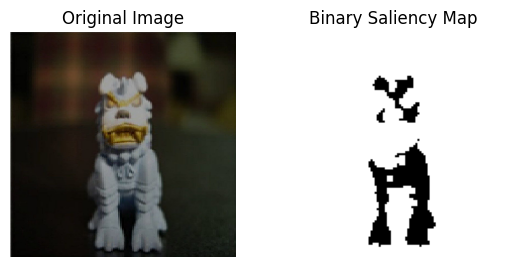

In [47]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\toy.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.15
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 29ms/step


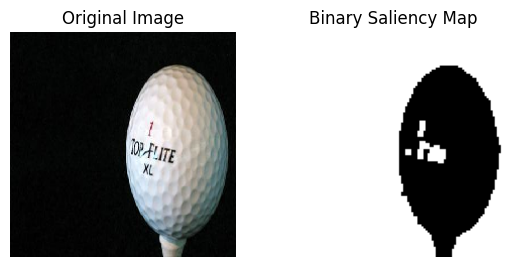

In [68]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\ball.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.173
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 29ms/step


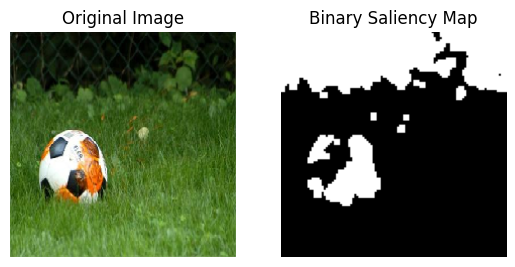

In [83]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\big ball.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.15
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 29ms/step


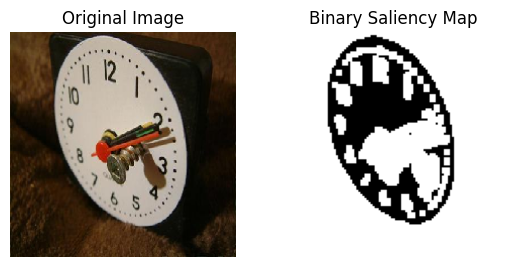

In [87]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\clock.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.16
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 28ms/step


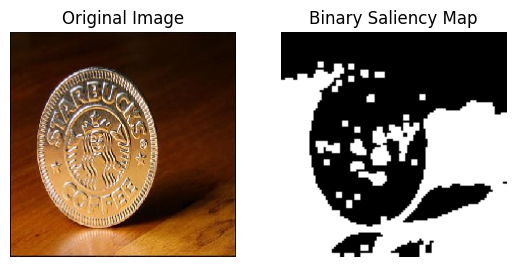

In [99]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\coin.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.22
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 31ms/step


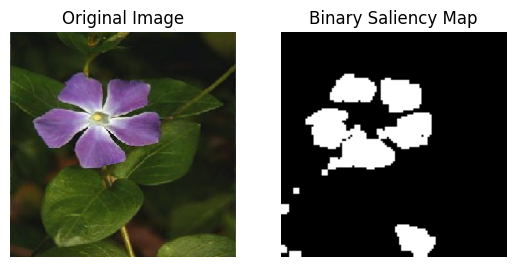

In [107]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\purple flower.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.19
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 28ms/step


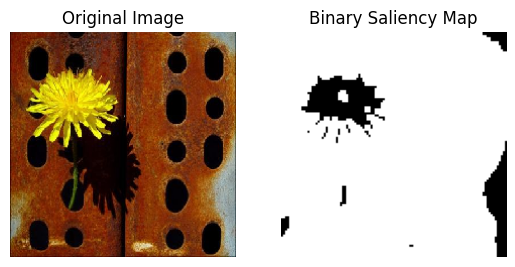

In [114]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\yellow flower.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.18
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 30ms/step


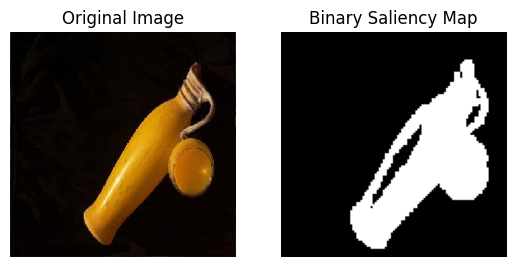

In [124]:
import cv2

# Assuming you have loaded an example image as 'input_image' using preprocess_image function
input_image = preprocess_image(r"C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\RE\images\yellow vase.jpg")
input_image = np.expand_dims(input_image, axis=0)

# Predict the saliency map for the example image
prediction = cnn_model.predict([input_image, input_image])[0]

threshold1 = 0.198
# Apply thresholding to the predicted saliency map
binary_prediction = np.where(prediction >= threshold1, 1, 0)

# Optional: Perform post-processing (e.g., binary dilation) to refine the binary saliency map
binary_prediction = np.squeeze(binary_prediction, axis=-1)  # Remove single-dimensional entry

kernel = np.ones((3, 3), np.uint8)
binary_prediction = cv2.dilate(binary_prediction.astype(np.uint8), kernel, iterations=1)

# Plot the original image and the binary saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_prediction, cmap='gray')
plt.title('Binary Saliency Map')
plt.axis('off')

plt.show()